In [119]:
# Import libraries

import pandas as pd
import numpy as np
import pickle
import csv
import scipy

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, GridSearchCV, learning_curve
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC

from matplotlib import pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns


Exploring data

In [48]:
# Load datasets

data = pd.read_csv("book_rating_train.csv")

test = pd.read_csv("book_rating_test.csv")


In [49]:
data.describe()

,PublishYear,PublishMonth,PublishDay,pagesNumber,rating_label
count,23063.000000,23063.000000,23063.000000,23063.000000,23063.000000
mean,1999.652951,6.336686,10.077267,282.540693,3.788709
std,8.027628,3.469946,10.242300,332.900018,0.502590
min,1852.000000,1.000000,1.000000,0.000000,3.000000
25%,1997.000000,3.000000,1.000000,165.000000,3.000000
50%,2002.000000,6.000000,5.000000,256.000000,4.000000
75%,2005.000000,9.000000,18.000000,352.000000,4.000000
max,2020.000000,12.000000,31.000000,37000.000000,5.000000


In [50]:
publishers = data['Publisher']

publishers_counts = publishers.value_counts()
publishers_counts
# plt.bar(publishers_counts.index, publishers_counts.values)
# plt.xlabel('Categories')
# plt.ylabel('Frequency')
# plt.title('Histogram of Categories')
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.show()

Publisher
Oxford University Press, USA    368
Cambridge University Press      275
Routledge                       269
Dover Publications              233
Penguin Books                   163
                               ... 
Frederick Fell Publishers         1
Diana/Mexico                      1
Clinamen Press Ltd.               1
Kuperard                          1
New Amsterdam Books               1
Name: count, Length: 4247, dtype: int64

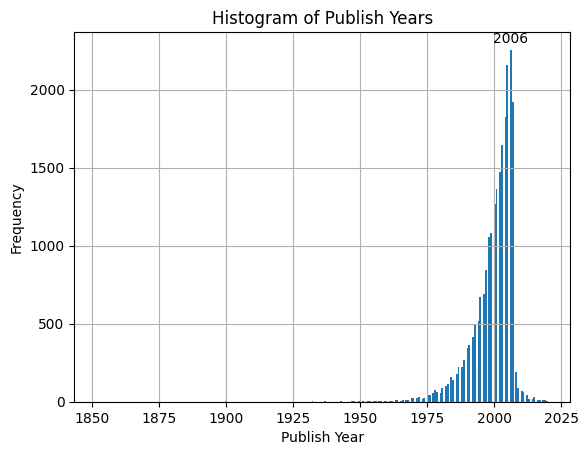

In [51]:
publish_year = data['PublishYear']

publish_counts = publish_year.value_counts()

plt.hist(publish_year, bins=250)  # Adjust the number of bins as needed
plt.xlabel('Publish Year')
plt.ylabel('Frequency')
plt.title('Histogram of Publish Years')
plt.grid(True)

highest_index = publish_counts.idxmax()

# Annotate the highest value
highest_value = publish_counts.max()
plt.annotate(highest_index, (highest_index, highest_value), xytext=(0, 5), textcoords='offset points', ha='center')

plt.show()

In [52]:
# Replace categorical data with numerical data

le = LabelEncoder()

label = le.fit_transform(data['Publisher'])
data.drop("Publisher", axis=1, inplace=True)
data['Publisher'] = label

label = le.fit_transform(data['Language'])
data.drop("Language", axis=1, inplace=True)
data['Language'] = label

label = le.fit_transform(test['Publisher'])
test.drop("Publisher", axis=1, inplace=True)
test['Publisher'] = label

label = le.fit_transform(test['Language'])
test.drop("Language", axis=1, inplace=True)
test['Language'] = label

Text Features

In [53]:
# Load vocab dictionaries provided

name_vocab = pickle.load(open("book_text_features_countvec/train_name_countvectorizer.pkl", "rb"))
name_vocab_dict = name_vocab.vocabulary_

author_vocab = pickle.load(open("book_text_features_countvec/train_authors_countvectorizer.pkl", "rb"))
author_vocab_dict = author_vocab.vocabulary_

desc_vocab = pickle.load(open("book_text_features_countvec/train_desc_countvectorizer.pkl", "rb"))
desc_vocab_dict = desc_vocab.vocabulary_

c:\Users\comfi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator CountVectorizer from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [54]:
# Load Bag of Word Vectorisers provided

name_bow = scipy.sparse.load_npz('book_text_features_countvec/train_name_vec.npz')
author_bow = scipy.sparse.load_npz('book_text_features_countvec/train_authors_vec.npz')
desc_bow = scipy.sparse.load_npz('book_text_features_countvec/train_desc_vec.npz')

test_name_bow = scipy.sparse.load_npz('book_text_features_countvec/test_name_vec.npz')
test_author_bow = scipy.sparse.load_npz('book_text_features_countvec/test_authors_vec.npz')
test_desc_bow = scipy.sparse.load_npz('book_text_features_countvec/test_desc_vec.npz')


In [55]:
# Load Doc 2 Vec matrices provided

name_doc2vec = pd.read_csv(r"book_text_features_doc2vec/train_name_doc2vec100.csv", index_col = False, delimiter = ',', header=None)
author_doc2vec = pd.read_csv(r"book_text_features_doc2vec/train_authors_doc2vec20.csv", index_col = False, delimiter = ',', header=None)
desc_doc2vec = pd.read_csv(r"book_text_features_doc2vec/train_desc_doc2vec100.csv", index_col = False, delimiter = ',', header=None)

test_name_doc2vec = pd.read_csv(r"book_text_features_doc2vec/test_name_doc2vec100.csv", index_col = False, delimiter = ',', header=None)
test_author_doc2vec = pd.read_csv(r"book_text_features_doc2vec/test_authors_doc2vec20.csv", index_col = False, delimiter = ',', header=None)
test_desc_doc2vec = pd.read_csv(r"book_text_features_doc2vec/test_desc_doc2vec100.csv", index_col = False, delimiter = ',', header=None)


In [56]:
# Embed Doc 2 Vec matrices into training dataset

desc_embeddings = [desc_doc2vec[i] for i in range(100)]
name_embeddings = [name_doc2vec[i] for i in range(100)]
auth_embeddings = [author_doc2vec[i] for i in range(20)]

new_columns = [f'desc{i}' for i in range(100)]
desc_df = pd.DataFrame(desc_embeddings).transpose()
desc_df.columns = new_columns

new_columns = [f'name{i}' for i in range(100)]
name_df = pd.DataFrame(name_embeddings).transpose()
name_df.columns = new_columns

new_columns = [f'auth{i}' for i in range(20)]
auth_df = pd.DataFrame(auth_embeddings).transpose()
auth_df.columns = new_columns

cat_features = data[['PublishYear', 'PublishMonth', 'PublishDay','pagesNumber', 'Publisher', 'Language']]
desc_features = pd.concat([desc_df, cat_features], axis=1)
auth_features = pd.concat([auth_df, desc_features], axis=1)
train_features = pd.concat([name_df, auth_features], axis=1)

ratings = data['rating_label']

In [57]:
# Embed Doc 2 Vec matrices into testing dataset

test_desc_embeddings = [test_desc_doc2vec[i] for i in range(100)]
test_name_embeddings = [test_name_doc2vec[i] for i in range(100)]
test_auth_embeddings = [test_author_doc2vec[i] for i in range(20)]

new_columns = [f'desc{i}' for i in range(100)]
test_desc_df = pd.DataFrame(test_desc_embeddings).transpose()
test_desc_df.columns = new_columns

new_columns = [f'name{i}' for i in range(100)]
test_name_df = pd.DataFrame(test_name_embeddings).transpose()
test_name_df.columns = new_columns

new_columns = [f'auth{i}' for i in range(20)]
test_auth_df = pd.DataFrame(test_auth_embeddings).transpose()
test_auth_df.columns = new_columns

test_cat_features = test[['PublishYear', 'PublishMonth', 'PublishDay','pagesNumber', 'Publisher', 'Language']]
test_desc_features = pd.concat([test_desc_df, test_cat_features], axis=1)
test_auth_features = pd.concat([test_auth_df, test_desc_features], axis=1)
test_features = pd.concat([test_name_df, test_auth_features], axis=1)

Missing Values

In [58]:
missing_values = train_features.isnull().sum()
train_features = train_features.dropna(axis=0)
ratings = ratings.dropna(axis=0)

Feature Selection: PMI

In [59]:
# Calculate PMI scores

pmi_scores = mutual_info_regression(train_features, ratings)
sorted_features = np.argsort(pmi_scores)[::-1]

In [60]:
# Select features based on PMI score

k = 20
selected_features = train_features.columns[sorted_features[:k]].tolist()
train_f = train_features[selected_features]
test_f = test_features[selected_features]

print(selected_features)

['Publisher', 'pagesNumber', 'desc87', 'name98', 'PublishYear', 'desc55', 'desc18', 'name79', 'desc33', 'auth14', 'desc72', 'desc78', 'desc64', 'name99', 'name57', 'desc93', 'name9', 'auth16', 'auth2', 'desc94']


Test Splitting

In [61]:
# Create data splits

X_train, X_test, y_train, y_test = train_test_split(train_f, ratings, test_size=0.2, random_state=42)

In [62]:
benchmark = list([y_train.mean()] * len(y_test))
print("Baseline MSE: ",'{0:0.2f}'.format((mean_squared_error(y_test, benchmark))))
print("Baseline R2: ",'{0:0.2f}'.format((r2_score(y_test, benchmark))))

Baseline MSE:  0.25
Baseline R2:  -0.00


Logistic Regression
* using k=50 : accuracy 70.412%
* using k=30 - takes way too long - accuracy same as k=20, settle with k=20
* using k=20 : accuracy 70.447% - training 71.125%
* using k=10 : training 71.103

In [73]:
# Hyperparameter tuning

model = LogisticRegression()

param_grid = {
    'C': [0.1, 1, 10],                 # Inverse of regularization strength
    'penalty': ['l1', 'l2'],           # Regularization type
    'solver': ['liblinear', 'saga']    # Solver algorithm
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

best_model = LogisticRegression(**best_params)

c:\Users\comfi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\comfi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\comfi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\comfi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\comfi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

In [74]:
best_model.fit(X_train, y_train)

predictions = best_model.predict(X_test)

c:\Users\comfi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


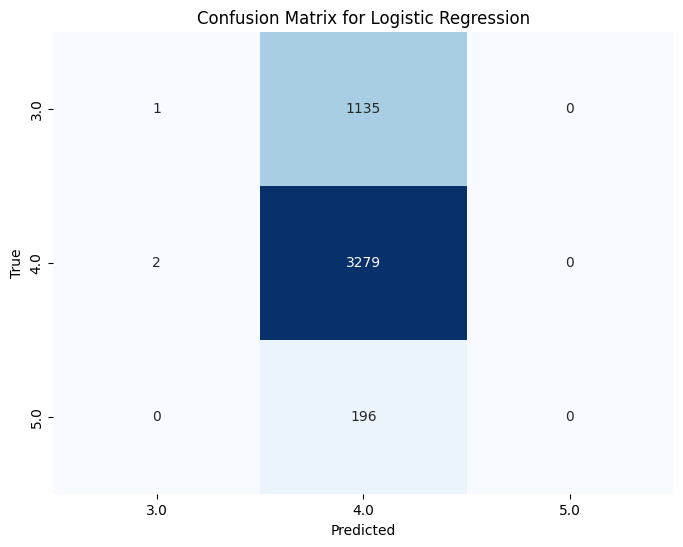

In [76]:
cm = confusion_matrix(y_test, predictions)
labels = np.unique(y_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

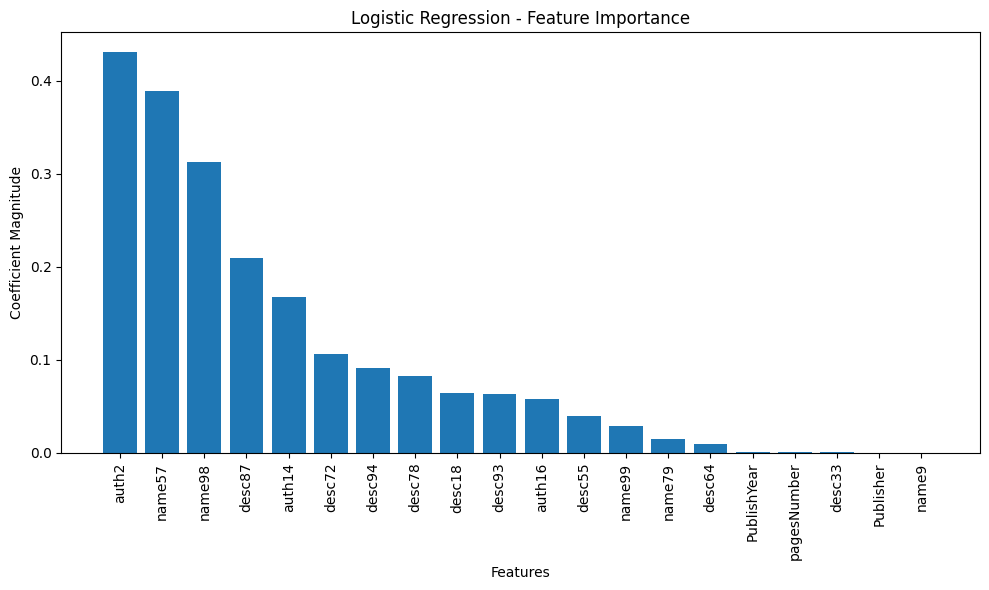

In [85]:
features = train_f.columns
coefficients = np.abs(best_model.coef_[0])
# Sort the coefficients in descending order
sorted_indices = np.argsort(coefficients)[::-1]
sorted_features = [features[i] for i in sorted_indices]

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(coefficients)), coefficients[sorted_indices], tick_label=sorted_features)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Coefficient Magnitude')
plt.title('Logistic Regression - Feature Importance')
plt.tight_layout()
plt.show()

c:\Users\comfi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\comfi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\comfi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\comfi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\comfi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warni

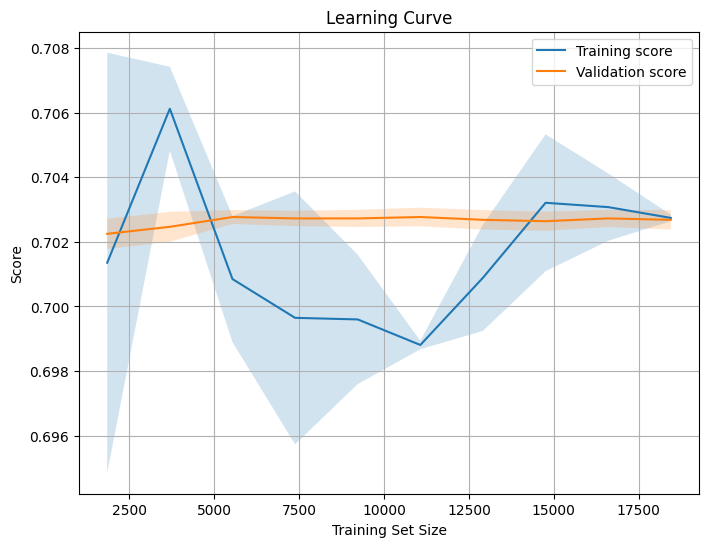

In [90]:
train_sizes = np.linspace(0.1, 1.0, 10)

# Calculate the learning curve scores
train_sizes, train_scores, valid_scores = learning_curve(best_model, train_f, ratings, train_sizes=train_sizes, cv=5)

# Calculate the mean and standard deviation of the scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

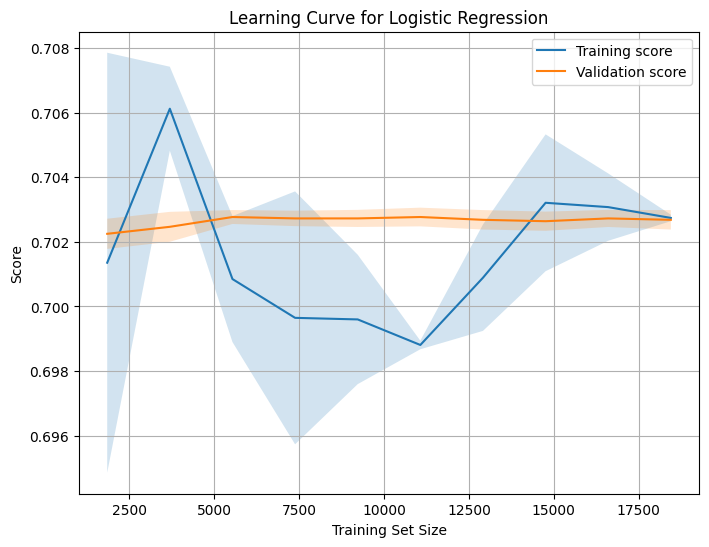

In [91]:
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
plt.plot(train_sizes, valid_scores_mean, label='Validation score')
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.2)
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.title('Learning Curve for Logistic Regression')
plt.legend()
plt.grid(True)
plt.show()

In [77]:
print("Best Parameters:", best_params)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: ", accuracy)
precision = precision_score(y_test, predictions, average='weighted')
print("Precision: ", precision)
recall = recall_score(y_test, predictions, average='weighted')
print("Recall: ", recall)
f1 = f1_score(y_test, predictions, average='weighted')
print("F1: ", f1)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy:  0.7110340342510297
Precision:  0.587985210772975
Recall:  0.7110340342510297
F1:  0.5915340287692809
MSE: 0.2889659657489703
R2: -0.16883238584307336


c:\Users\comfi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [65]:
best_model.fit(train_f, ratings)
predictions = best_model.predict(test_f)

c:\Users\comfi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [66]:
with open("logistic_regression.csv", 'w', newline='') as file:
    writer = csv.writer(file)
    i = 1
    writer.writerow(['id','rating_label'])
    for prediction in predictions:
        writer.writerow([i, prediction])
        i += 1

Random Forest Classification
* kaggle accuracy: 70.586

In [168]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier()

# Perform Randomized Search Cross Validation
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=10,
                               scoring='neg_mean_squared_error', cv=5, verbose=1, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(train_f, ratings, test_size=0.2, random_state=42)
rf_random.fit(X_train, y_train)

# Get the best parameters and model
best_params = rf_random.best_params_
rf_best_model = rf_random.best_estimator_

# Evaluate the best model on the validation set
predictions = rf_best_model.predict(X_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5; 1/36] START max_depth=30, min_samples_split=2, n_estimators=100........
[CV 1/5; 1/36] END max_depth=30, min_samples_split=2, n_estimators=100;, score=-0.297 total time=  24.0s
[CV 2/5; 1/36] START max_depth=30, min_samples_split=2, n_estimators=100........
[CV 2/5; 1/36] END max_depth=30, min_samples_split=2, n_estimators=100;, score=-0.300 total time=  23.5s
[CV 3/5; 1/36] START max_depth=30, min_samples_split=2, n_estimators=100........
[CV 3/5; 1/36] END max_depth=30, min_samples_split=2, n_estimators=100;, score=-0.301 total time=  24.8s
[CV 4/5; 1/36] START max_depth=30, min_samples_split=2, n_estimators=100........
[CV 4/5; 1/36] END max_depth=30, min_samples_split=2, n_estimators=100;, score=-0.298 total time=  19.2s
[CV 5/5; 1/36] START max_depth=30, min_samples_split=2, n_estimators=100........
[CV 5/5; 1/36] END max_depth=30, min_samples_split=2, n_estimators=100;, score=-0.297 total time=  18.0s
[CV 1/5;

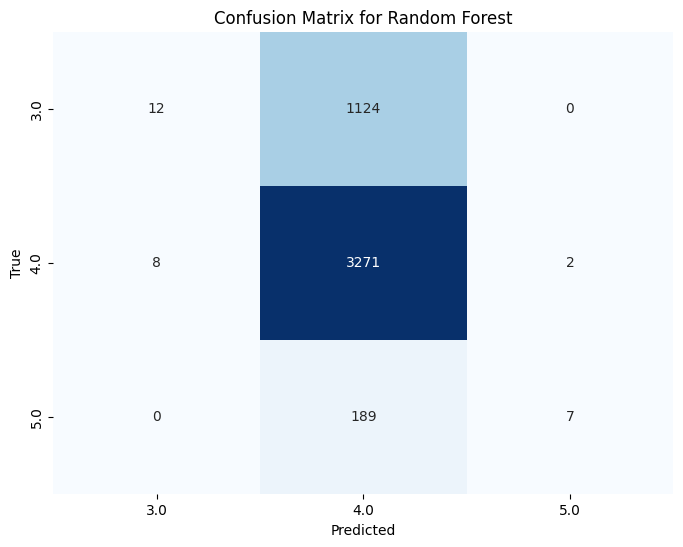

In [169]:
cm = confusion_matrix(y_test, predictions)
labels = np.unique(y_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Random Forest')
plt.show()

In [170]:
train_sizes = np.linspace(0.1, 1.0, 10)

# Calculate the learning curve scores
train_sizes, train_scores, valid_scores = learning_curve(rf_best_model, train_f, ratings, train_sizes=train_sizes, cv=5)

# Calculate the mean and standard deviation of the scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

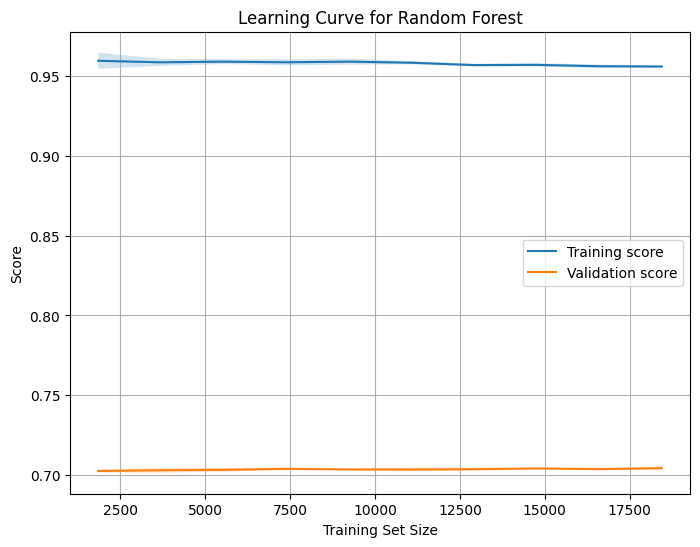

In [175]:
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
plt.plot(train_sizes, valid_scores_mean, label='Validation score')
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.2)
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.title('Learning Curve for Random Forest')
plt.legend()
plt.grid(True)
plt.show()

In [172]:
print("Best Parameters:", best_params)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: ", accuracy)
precision = precision_score(y_test, predictions, average='weighted')
print("Precision: ", precision)
recall = recall_score(y_test, predictions, average='weighted')
print("Recall: ", recall)
f1 = f1_score(y_test, predictions, average='weighted')
print("F1: ", f1)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

Best Parameters: {'max_depth': 30, 'min_samples_split': 10, 'n_estimators': 300}
Accuracy:  0.7132018209408194
Precision:  0.6883295299333004
Recall:  0.7132018209408194
F1:  0.5996230878652149
MSE: 0.2867981790591806
R2: -0.16006395084049974


In [173]:
rf_best_model.fit(train_f, ratings)
predictions = rf_best_model.predict(test_f)

In [174]:
with open("random_forest.csv", 'w', newline='') as file:
    writer = csv.writer(file)
    i = 1
    writer.writerow(['id','rating_label'])
    for prediction in predictions:
        writer.writerow([i, prediction])
        i += 1

Naive Bayes Model

In [176]:
nb_model = GaussianNB()

param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6],  # Smoothing parameter
}

X_train, X_test, y_train, y_test = train_test_split(train_f, ratings, test_size=0.2, random_state=42)

grid_search = GridSearchCV(nb_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best model and its hyperparameters
nb_best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions on the test data using the best model
predictions = nb_best_model.predict(X_test)


In [126]:
print("Best Parameters:", best_params)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: ", accuracy)
precision = precision_score(y_test, predictions, average='weighted')
print("Precision: ", precision)
recall = recall_score(y_test, predictions, average='weighted')
print("Recall: ", recall)
f1 = f1_score(y_test, predictions, average='weighted')
print("F1: ", f1)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

Best Parameters: {'var_smoothing': 1e-06}
Accuracy:  0.7060481248645133
Precision:  0.665802708271933
Recall:  0.7060481248645133
F1:  0.5964174904131456
MSE: 0.29655321916323435
R2: -0.1995219083520814


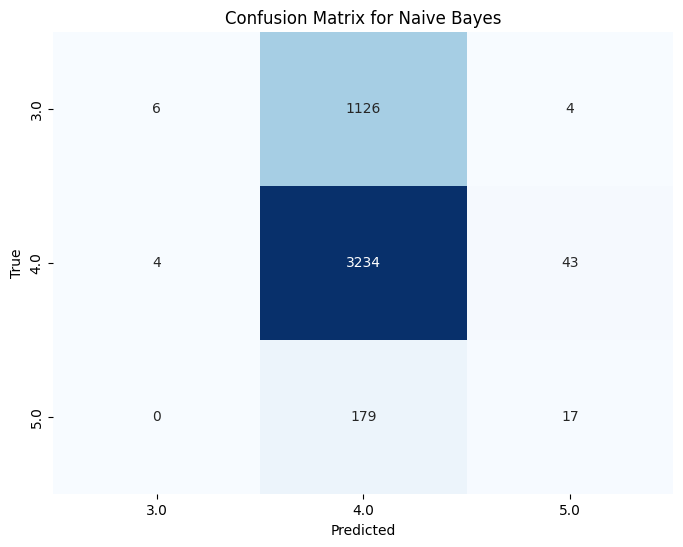

In [178]:
cm = confusion_matrix(y_test, predictions)
labels = np.unique(y_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Naive Bayes')
plt.show()

In [179]:
train_sizes = np.linspace(0.1, 1.0, 10)

# Calculate the learning curve scores
train_sizes, train_scores, valid_scores = learning_curve(nb_best_model, train_f, ratings, train_sizes=train_sizes, cv=5)

# Calculate the mean and standard deviation of the scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

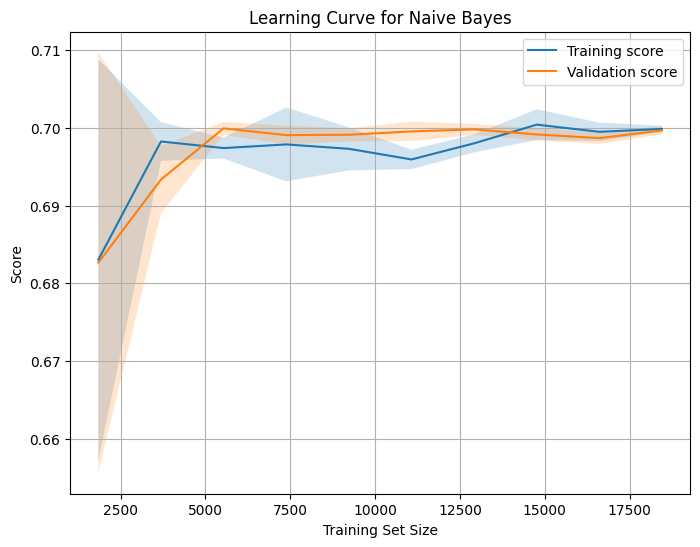

In [180]:
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
plt.plot(train_sizes, valid_scores_mean, label='Validation score')
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.2)
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.title('Learning Curve for Naive Bayes')
plt.legend()
plt.grid(True)
plt.show()

In [129]:
nb_best_model.fit(train_f, ratings)
predictions = nb_best_model.predict(test_f)

In [130]:
with open("naive_bayes.csv", 'w', newline='') as file:
    writer = csv.writer(file)
    i = 1
    writer.writerow(['id','rating_label'])
    for prediction in predictions:
        writer.writerow([i, prediction])
        i += 1

Metric Graph making

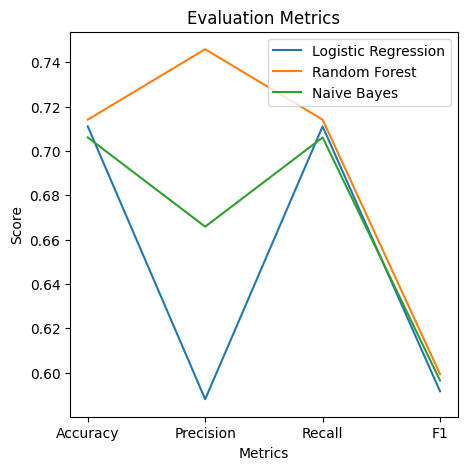

In [161]:
col = ['Accuracy', 'Precision', 'Recall', 'F1']
row = ['Logistic Regression', 'Random Forest', 'Naive Bayes']

lr = [0.711034, 0.587985, 0.711034, 0.591534]
rf = [0.714069, 0.745835, 0.714069, 0.599284]
nb = [0.706048, 0.665803, 0.706048, 0.596417]

metrics = np.array([lr, rf, nb])
x = range(1, metrics.shape[1] + 1)

fig, ax = plt.subplots(figsize=(5, 5))

for i in range(metrics.shape[0]):
    ax.plot(x, metrics[i, :], label=f'{row[i]}')

ax.set_xticks(x)
ax.set_xticklabels(col)

ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Evaluation Metrics')

ax.legend()
plt.show()
